In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [29]:
os.listdir('/content/drive/MyDrive/FOOT DECEASE')

['train_set', 'test_set']

In [30]:
BATCH_SIZE = 32
IMAGE_SIZE = (128, 128)

train_data_dir = "/content/drive/MyDrive/FOOT DECEASE/train_set"
test_data_dir = "/content/drive/MyDrive/FOOT DECEASE/test_set"

In [31]:
train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='training',
                                                         validation_split=0.1,
                                                         seed=42)

validation_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='validation',
                                                         validation_split=0.1,
                                                         seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE)

Found 676 files belonging to 3 classes.
Using 609 files for training.
Found 676 files belonging to 3 classes.
Using 67 files for validation.
Found 255 files belonging to 3 classes.


In [32]:
class_names = train_data.class_names
print(class_names)

['athlete-foot', 'foot-corn', 'invalid-Image']


In [7]:
for image_batch, label_batch in train_data.take(1):
    print(image_batch.shape)
    print(label_batch.shape)


(32, 128, 128, 3)
(32,)


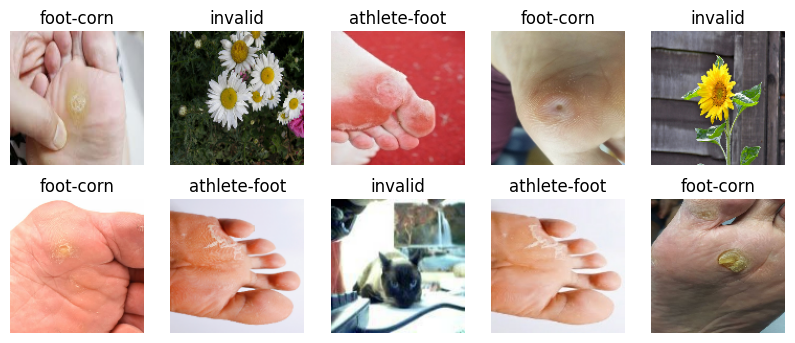

In [8]:
plt.figure(figsize=(10, 4))
for images, labels in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [9]:
train_data = train_data.map(lambda x, y: (x / 255, y))
validation_data = validation_data.map(lambda x, y: (x / 255, y))
test_data = test_data.map(lambda x, y: (x / 255, y))


In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", input_shape=(128, 128, 3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

In [11]:
# Hyperparameters
conv_filters = [32, 64, 128]
kernel_size = 3
dense_units = [128, 128, 32]
dropout_rate = 0.2
learning_rate = 0.001

In [12]:
#model
num_classes = 3

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 127008)            0         
                                                                 
 dense (Dense)               (None, 64)                8128576   
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 8129667 (31.01 MB)
Trainable params: 8129667 (31.01 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [15]:
start_time = time.time()

history = model.fit(train_data, epochs=10, validation_data=validation_data)

end_time = time.time()

Epoch 1/10
20/20 [==============================] - 54s 3s/step - loss: 3.5372 - accuracy: 0.4581 - val_loss: 0.9188 - val_accuracy: 0.6269
Epoch 2/10
20/20 [==============================] - 3s 114ms/step - loss: 0.6924 - accuracy: 0.6305 - val_loss: 0.5382 - val_accuracy: 0.7463
Epoch 3/10
20/20 [==============================] - 4s 132ms/step - loss: 0.4892 - accuracy: 0.7964 - val_loss: 0.4854 - val_accuracy: 0.7761
Epoch 4/10
20/20 [==============================] - 3s 102ms/step - loss: 0.3951 - accuracy: 0.8571 - val_loss: 0.5087 - val_accuracy: 0.7463
Epoch 5/10
20/20 [==============================] - 3s 102ms/step - loss: 0.3558 - accuracy: 0.8834 - val_loss: 0.4832 - val_accuracy: 0.7761
Epoch 6/10
20/20 [==============================] - 3s 102ms/step - loss: 0.2530 - accuracy: 0.9360 - val_loss: 0.3024 - val_accuracy: 0.8507
Epoch 7/10
20/20 [==============================] - 4s 113ms/step - loss: 0.2332 - accuracy: 0.9212 - val_loss: 0.3078 - val_accuracy: 0.8657
Epoch 8/

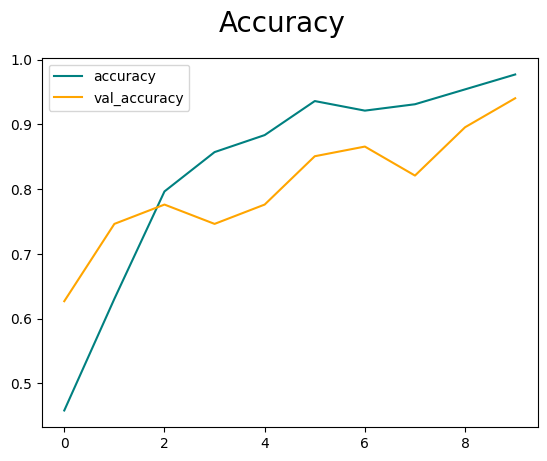

In [16]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend()
plt.show()

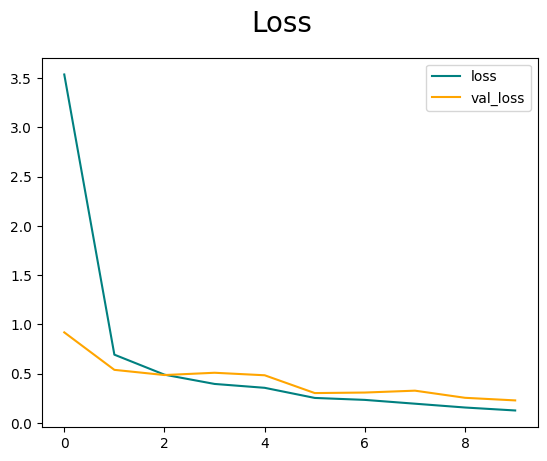

In [17]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend()
plt.show()

In [18]:
# For evaluating precision, recall, and accuracy in a multi-classes
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.CategoricalAccuracy()


In [19]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat = tf.argmax(yhat, axis=1)  # Convert predictions to class indices
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)


1/1 [==============================] - 0s 170ms/step


In [20]:
print('Precision:', precision.result().numpy())
print('Recall:', recall.result().numpy())
print('Accuracy:', accuracy.result().numpy())


Precision: 0.9823009
Recall: 0.9866667
Accuracy: 1.0


In [22]:
# Load and preprocess an image using TensorFlow
img_path = '/content/drive/MyDrive/FOOT DECEASE/test_set/athlete-foot/athlete-foot 233.jpeg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

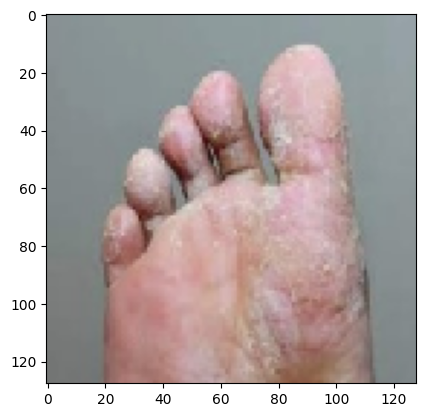

In [23]:
plt.imshow(img_array[0].numpy().astype('uint8')) # Convert the EagerTensor to a NumPy array using .numpy()
plt.show()

In [24]:
yhat = model.predict(img_array / 255)
predicted_class = np.argmax(yhat, axis=1)


1/1 [==============================] - 0s 28ms/step


In [25]:
print(f'Predicted class: {class_names[predicted_class[0]]}')


Predicted class: athlete-foot


In [26]:
model.save('model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
